<a href="https://colab.research.google.com/github/AKASH4671/AI-Powered-Portfolio-Optimization-and-Risk-Management/blob/main/2_1_convex_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Max Sharpe Portfolio via Convex Optimization (Shorting Allowed)**

### 💼 Financial Intuition

In real-world portfolio management, investors aim to **maximize their risk-adjusted return**, not just return. The **Sharpe Ratio** helps us quantify this by measuring how much **excess return** we earn per unit of risk taken:

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

* $R_p$ = Expected portfolio return
* $R_f$ = Risk-free rate (e.g., treasury bonds)
* $\sigma_p$ = Portfolio volatility (standard deviation)

By **maximizing the Sharpe Ratio**, we’re choosing the most “efficient” portfolio — the one that gives us the most bang for our risk buck.

> ⚠️ In this first step, we allow **short selling**, meaning portfolio weights can be negative. This assumes the investor can borrow stocks to sell them in hopes of buying back later at a lower price. It's more aggressive and flexible but riskier.

---

### **Mathematical Optimization**

We use **convex optimization** to solve for the weights that maximize Sharpe. Since optimization libraries usually **minimize functions**, we minimize the **negative Sharpe Ratio**.

#### Objective Function:

$$
\text{Minimize } -\left( \frac{w^T \mu - R_f}{\sqrt{w^T \Sigma w}} \right)
$$

Where:

* $w$ = vector of asset weights
* $\mu$ = vector of expected returns
* $\Sigma$ = covariance matrix of returns
* $w^T \mu$ = expected portfolio return
* $\sqrt{w^T \Sigma w}$ = portfolio volatility

#### Constraints:

* **Sum of Weights = 1** → we must invest 100% of capital
* **Weights ∈ \[-1, 1]** → allows shorting (up to -100%)

#### Behind the Scenes:

* We initialize weights equally (e.g., 1/6 for 6 assets)
* The optimizer adjusts these weights to find the point where Sharpe is maximized
* It uses **Sequential Least Squares Programming (SLSQP)** — a powerful method for handling both equality constraints (sum of weights) and bounds (shorting)

---

###Real-World Use Case

Portfolio managers use this method to **build core asset allocations**, balancing risk and reward in line with their strategy:

* **Aggressive funds** might allow shorting to hedge or speculate
* **Pension or index funds** typically disallow shorting — we'll solve for that case next





In [5]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import yfinance as yf

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Set working directory
import os
project_path = '/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Powered-Portfolio-Optimization-and-Risk-Management'
os.chdir(project_path)


# Load data
returns = pd.read_csv("data/daily_returns.csv", index_col=0)
tickers = returns.columns
mean_returns = returns.mean()
cov_matrix = returns.cov()
rf = 0.03  # risk-free rate (3% annualized)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📈 Max Sharpe Portfolio (with shorting allowed)
Expected Return: 0.7032
Volatility (Risk): 0.4125
Sharpe Ratio: 1.632
Weights:
AAPL: 0.4994
AMZN: -0.4076
GS: 0.2359
JNJ: -0.5096
JPM: -0.0587
MSFT: -0.2771
NVDA: 0.653
UNH: 0.0345
WMT: 0.8289
XOM: 0.0012


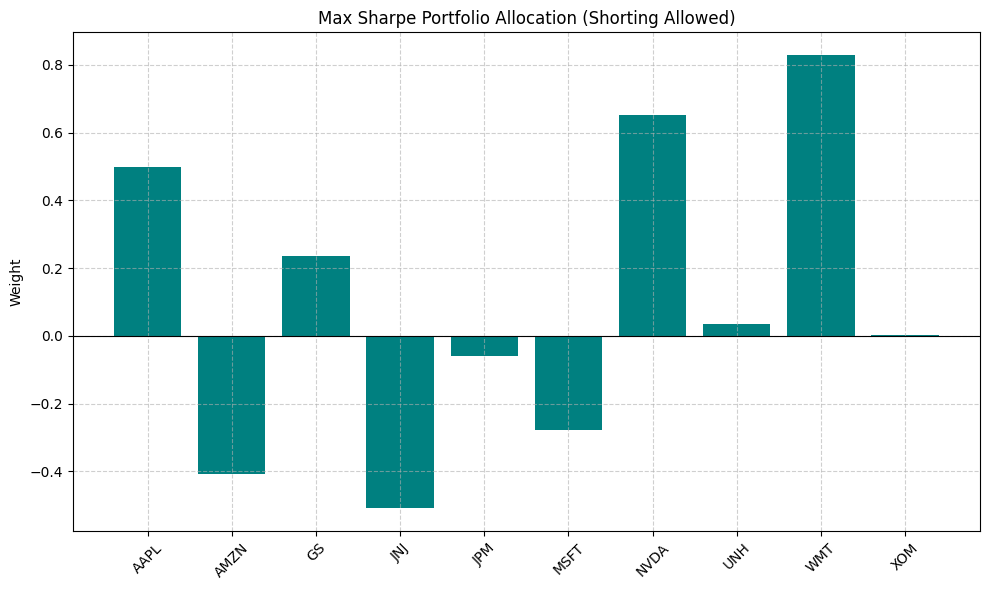

In [3]:
# ---------------------------
# 1. Max Sharpe Portfolio (with shorting allowed)
# ---------------------------

def portfolio_performance(weights, mean_returns, cov_matrix, rf):
    """
    Calculates portfolio return, volatility, and Sharpe ratio.
    """
    portfolio_return = np.dot(weights, mean_returns) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    """
    Objective function: minimize negative Sharpe Ratio.
    """
    return -portfolio_performance(weights, mean_returns, cov_matrix, rf)[2]

def check_sum(weights):
    """
    Constraint: weights must sum to 1.
    """
    return np.sum(weights) - 1

# Setup
num_assets = len(tickers)
initial_weights = np.ones(num_assets) / num_assets
bounds = tuple((-1, 1) for _ in range(num_assets))  # shorting allowed
constraints = {'type': 'eq', 'fun': check_sum}

# Optimization
max_sharpe_result = minimize(
    neg_sharpe_ratio,
    initial_weights,
    args=(mean_returns, cov_matrix, rf),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Extract results
optimal_weights_sharpe = max_sharpe_result.x
ret, vol, sharpe = portfolio_performance(optimal_weights_sharpe, mean_returns, cov_matrix, rf)

# Print results
print("📈 Max Sharpe Portfolio (with shorting allowed)")
print("Expected Return:", round(ret, 4))
print("Volatility (Risk):", round(vol, 4))
print("Sharpe Ratio:", round(sharpe, 4))
print("Weights:")
for ticker, weight in zip(tickers, optimal_weights_sharpe):
    print(f"{ticker}: {round(weight, 4)}")

# Plot portfolio allocation
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights_sharpe, color='teal')
plt.title("Max Sharpe Portfolio Allocation (Shorting Allowed)")
plt.ylabel("Weight")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save plot to GDrive
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/max_sharpe_allocation_shorting.png")
plt.show()


###**Max Sharpe Portfolio (No Shorting Allowed)**

💼 **Financial Intuition:**  
In this variation, we **restrict short selling** — meaning the investor can only allocate capital to long positions (buying stocks). All weights must be between 0% and 100%. This is more conservative, realistic for retail investors, and often required by regulation (e.g., mutual funds).

**Mathematical Setup:**  
We keep the objective the same — **maximize Sharpe Ratio** — but now:
- Weights are bounded between 0 and 1 (no negative weights)
- Still use SLSQP to minimize the negative Sharpe Ratio

**What changes?**  
- Optimizer can’t "bet against" any asset.
- Asset allocation may become concentrated (e.g., few large weights instead of many small ones).



📈 Max Sharpe Portfolio (No Shorting Allowed)
Expected Return: 0.4466
Volatility (Risk): 0.2754
Sharpe Ratio: 1.5129
Weights:
AAPL: 0.1114
AMZN: 0.0
GS: 0.0588
JNJ: 0.0
JPM: 0.0
MSFT: 0.0
NVDA: 0.3906
UNH: 0.0
WMT: 0.4353
XOM: 0.0039


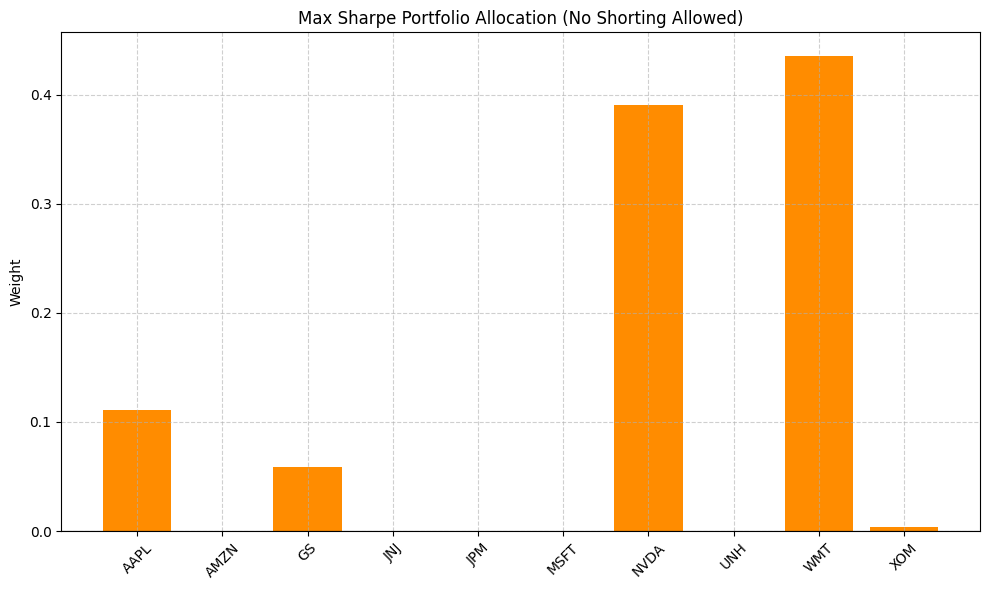

In [4]:
# Bounds: no shorting allowed (weights between 0 and 1)
no_short_bounds = tuple((0, 1) for asset in range(num_assets))

# Optimization
max_sharpe_noshort_result = minimize(
    neg_sharpe_ratio,
    initial_weights,
    args=(mean_returns, cov_matrix, rf),
    method='SLSQP',
    bounds=no_short_bounds,
    constraints=constraints
)

# Extract results
optimal_weights_noshort = max_sharpe_noshort_result.x
ret_noshort, vol_noshort, sharpe_noshort = portfolio_performance(optimal_weights_noshort, mean_returns, cov_matrix, rf)

# Print results
print("\n📈 Max Sharpe Portfolio (No Shorting Allowed)")
print("Expected Return:", round(ret_noshort, 4))
print("Volatility (Risk):", round(vol_noshort, 4))
print("Sharpe Ratio:", round(sharpe_noshort, 4))
print("Weights:")
for ticker, weight in zip(tickers, optimal_weights_noshort):
    print(f"{ticker}: {round(weight, 4)}")

# Plot allocation
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights_noshort, color='darkorange')
plt.title("Max Sharpe Portfolio Allocation (No Shorting Allowed)")
plt.ylabel("Weight")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("plots/max_sharpe_allocation_noshort.png")
plt.show()


###**Minimum Variance Portfolio (MVP)**

💼 **Finance Intuition:**  
This portfolio **minimizes total risk (volatility)** regardless of return. It’s ideal for **risk-averse investors** who want the **most stable portfolio**. It forms the **leftmost point** on the Efficient Frontier.

**Math Insight:**  
The optimization goal is to **minimize portfolio volatility**, calculated as:  
$$
\sigma_p = \sqrt{w^T \Sigma w}
$$

Subject to:  
- weights sum to 1  
- (optionally) no shorting


🟩 Minimum Variance Portfolio (No Shorting)
Expected Return: 0.1436
Volatility (Risk): 0.1598
Sharpe Ratio: 0.7105
Weights:
AAPL: 0.0
AMZN: 0.091
GS: 0.0
JNJ: 0.4583
JPM: 0.0055
MSFT: 0.0
NVDA: 0.0
UNH: 0.0256
WMT: 0.3173
XOM: 0.1023


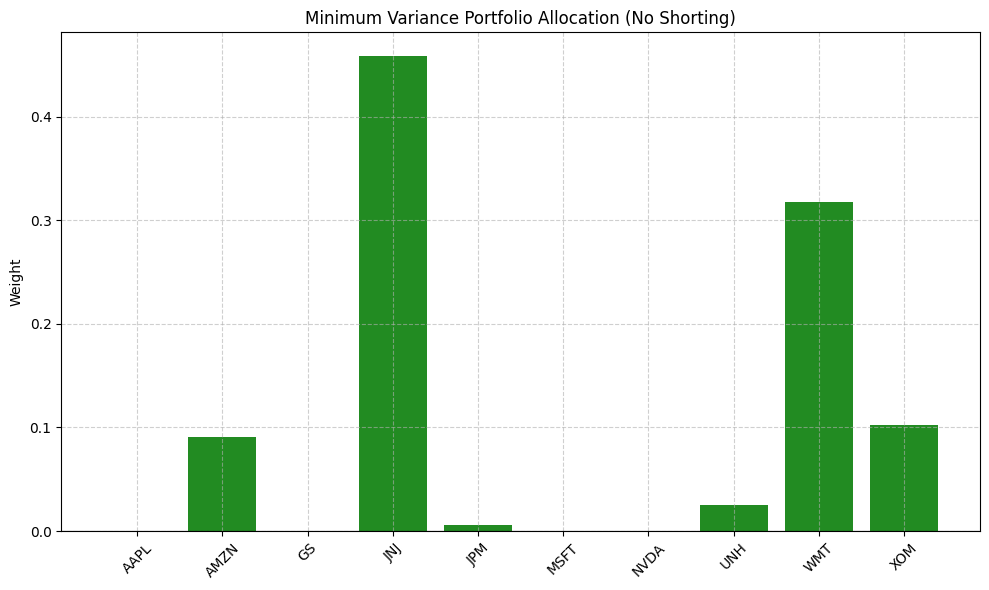

In [8]:
def portfolio_volatility(weights, cov_matrix):
    """
    Calculates portfolio volatility (standard deviation).
    """
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))

# Optimization for MVP (no shorting allowed)
min_var_result = minimize(
    portfolio_volatility,
    initial_weights,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=no_short_bounds,
    constraints=constraints
)

optimal_weights_minvar = min_var_result.x
ret_minvar, vol_minvar, sharpe_minvar = portfolio_performance(optimal_weights_minvar, mean_returns, cov_matrix, rf)

# Print results
print("\n🟩 Minimum Variance Portfolio (No Shorting)")
print("Expected Return:", round(ret_minvar, 4))
print("Volatility (Risk):", round(vol_minvar, 4))
print("Sharpe Ratio:", round(sharpe_minvar, 4))
print("Weights:")
for ticker, weight in zip(tickers, optimal_weights_minvar):
    print(f"{ticker}: {round(weight, 4)}")

# Plot allocation
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights_minvar, color='forestgreen')
plt.title("Minimum Variance Portfolio Allocation (No Shorting)")
plt.ylabel("Weight")
plt.xticks(rotation=45)
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("plots/min_var_allocation.png")
plt.show()




###**Efficient Frontier (Convex Optimization)**

💼 **Finance Intuition:**  
The Efficient Frontier shows the **best possible risk-return tradeoffs**. Each point represents a portfolio with the **highest return for a given risk**. Investors choose based on risk appetite.

**Math Insight:**  
We solve multiple optimizations, each time targeting a different portfolio return, and minimize volatility.  
This forms a **convex curve** that embodies **Markowitz’s Modern Portfolio Theory (MPT)**.


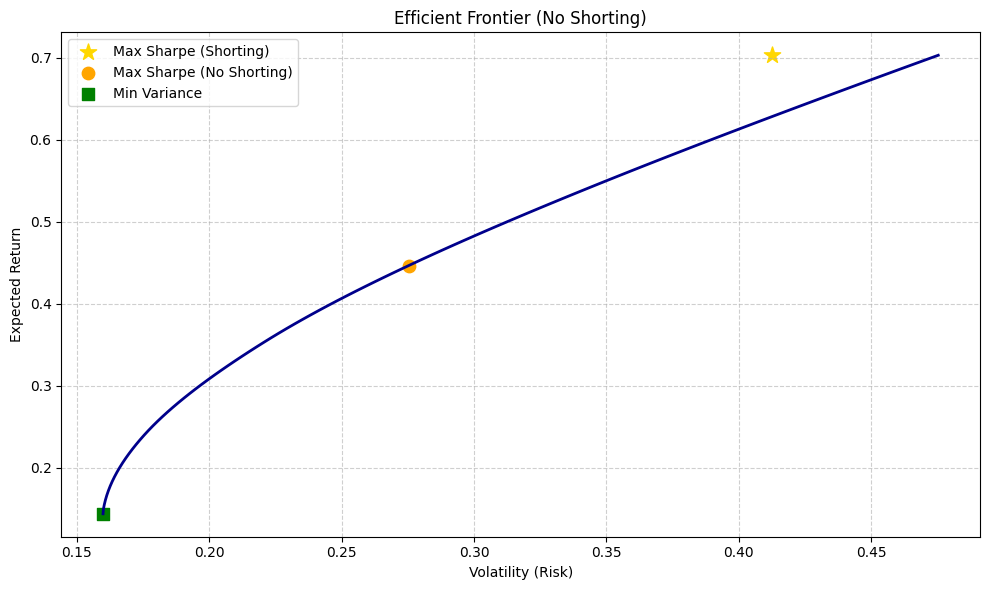

In [9]:
target_returns = np.linspace(ret_minvar, ret, 100)
efficient_vols = []
efficient_weights = []

for target in target_returns:
    constraints_ef = (
        {'type': 'eq', 'fun': check_sum},
        {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) * 252 - target}
    )
    result = minimize(
        portfolio_volatility,
        initial_weights,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=no_short_bounds,
        constraints=constraints_ef
    )
    if result.success:
        efficient_vols.append(result.fun)
        efficient_weights.append(result.x)
    else:
        efficient_vols.append(np.nan)
        efficient_weights.append([np.nan]*num_assets)

# Plot Efficient Frontier
plt.figure(figsize=(10, 6))
plt.plot(efficient_vols, target_returns, color='darkblue', linewidth=2)
plt.scatter(vol, ret, marker='*', color='gold', s=150, label='Max Sharpe (Shorting)')
plt.scatter(vol_noshort, ret_noshort, marker='o', color='orange', s=80, label='Max Sharpe (No Shorting)')
plt.scatter(vol_minvar, ret_minvar, marker='s', color='green', s=80, label='Min Variance')
plt.title("Efficient Frontier (No Shorting)")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("plots/efficient_frontier.png")
plt.show()
